# A Generating Automaton Model

Finite state automata associate a finite input alphabet with a set of discrete states through a deterministic transition function. Hybrid automata, an extension of FSAs, enable modeling scenarios involving a continuous input function rather than a discrete alphabet. A common example is a two-state thermostat mechanism that turns on or off in accordance with the thermodynamic state of a room. 

Biological systems consist of complex, interatcting sets of generating processes, where agents with a finite set of behaviors are generated through production of perfect or imperfect copies. For example, a simple gene transcription, translation, regulation loop produces copies of a protein each with discrete behaviors such as substrate binding or catalysis. An individual protein's state transitions may be modeled discretely. E.g., substrate bound or unbound, as in the case of the oxygen binding protein hemoglobin. However, the aggregate dynamics of many hemoglobins should be modeled continuously. E.g., via binding equilibrium:

$$
\theta= \frac{[S]^n}{k_d+[S]^n}
$$

Where $\theta$ is the unbound protein fraction for any concentration of substrate $[S]$, $k_d$ is the constant of dissociation, and $n$ is the Hill coefficient. 

The physiologically relevant computation for a gene encoding a binding protein is "how many protein copies to make to establish a stable binding equilibrium over time?". This requires a dynamic computing regime that adaptively responds to a range of changing conditions. 

This phenomenon occurs at many length and time scales in biological systems. For example - how many molecules of hemoglobin per erythrocyte? How many erythrocytes per total blood volume? Each of these generating processes involve making copies of biological structures that are relatively uniform and coupling the continuous aggregate dynamics with the generating and decay dynamics through feedback mechanisms.

**The goal of this project** is to develop a hybrid automaton that dynamically generates finite state machines in a manner that will trend toward homeostatic equilibrium. The structure of the automaton enables it to meet the demands of a target problem in a manner that is robust to fluctuations.

To keep the example easy to visualize, a simple macroscopic example is presented - **A generating automaton that produces simple turnstile machines for dynamic access control of a queue**. The model dyanmically computes the stable equilibrium with arriving people in the queue by making copies of the turnstiles in proportion to their use. 

## Properties
 
* Task parallelization. Making a copy of this system with varitaion would enable the whole unit to potentially handle related tasks in parallel. This may be similar to the way that bacterial genomes work by template encoding a string of gene sequences. If a sequence replicates with its promotor intact, then the new sequence is a string of parallel generating processes. 
* This simple model has limited degrees of freedom in the FSAs. This could be modified by allowing them to have modified degrees of freedom. E.g., post translational modifications, interactions between the FSAs, or by 'error prone' duplication that creates variety in the FSA states or transition functions. 
* Ultimately the advantage of this approach is to encapsulate the discrete computational logic and the continuous homeostatic properties of the system in one model. These could certainly be modeled separately, but an integrated view may provide insight that is not apparent when dynamics and computation are viewed separately. In biological systems, the software is the hardware... 

## Formal Definition

A deterministic **Generating Automaton** is formally defined as the 7-tuple:

$$
M = (Q, \Sigma, \delta, \rho, s_0, N_0, F)
$$

where:

- $Q$ is a finite set of turnstile states, e.g., $Q = \{L, U\}$ representing "Locked" and "Unlocked".

- $\Sigma$ is a finite set of input symbols (events), e.g., $\Sigma = \{\text{coin}, \text{push}\}$.

- $\delta: Q \times \Sigma \rightarrow Q$ is the state transition function of individual turnstiles:

$$
s_i(t + \Delta t) = \delta(s_i(t), e_i(t)), \quad e_i(t) \in \Sigma
$$

where $s_i$ is the current internal state of the $i^{th}$ turnstile.

- $\rho$: a continuous function that describes generating dynamics including growth, feedback, and decay.

- $s_0 \in Q$ is the initial state of newly replicated turnstiles, here $s_0 = L$ (Locked).

- $N_0 \in \mathbb{Z}_{>0}$ is the initial number of turnstiles at $t=0$.

- $F \in Q$ is the accepted state. In the case of the turnstile, there is no accepted state because the turnstile resets each lock/unlock cycle. 

---

**Model Dynamics**

In this scenario, a single turnstile provides access control. People arrive to a queue and pass through in accordance with the state transitions of the turnstile. The time distribution of the arrivals could follow any distribution, but a discrete time Poisson distribution is used here since these are typically used in stochastic queueing problems. In this distribution,  ($\lambda$) is the average number of people arriving per unit time, and time between arrivals is exponentially distributed. 

Each turnstile is a simple finite state automaton, but the computational model includes parameters that enable the turnstiles to generate self-copies and decay at rates that are proportional to their use. This creates feedback between the number of turnstiles and the number of people arriving in the queue. Thus, the computation isn't just about the finite state transitions of each machine, but also about the 'choice' of how many turnstiles to keep active at any given time. 

Each turnstile individually follows finite state machine logic, updating states independently according to the transition function:

$$
s_i(t+\Delta t) = \delta(s_i(t), e_i(t)), \quad e_i(t)\in\Sigma
$$

For the dynamics, let $N(t)$ denote the number of turnstiles and $q_s(t)$ denote the queue size at time $t$.

$$
\frac{dN}{dt}=\rho(q_s, N)=\alpha \cdot min(q_s(t), \mu\,N(t)) - \gamma\,N(t)
$$

Where $\alpha$ is a replication rate constant, $\mu$ is the maximal service rate per turnstile and $\gamma$ is the turnstile decay rate. The current queue size $q_s(t)$ depends on the number of new arrivals $A(t)$ and decreases with service by turnstiles:

$$
\frac{dq_s}{dt} = A(t) -  \mu\,N(t)
$$

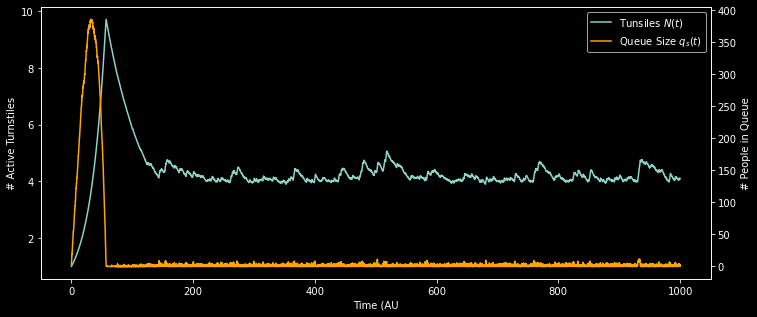

In [15]:
# Simple model simulation 

import numpy as np
import random 
import matplotlib.pyplot as plt

# Parameters
alpha= .05 # replication rate constant - turnstiles/time 
gamma= .01 # decay rate constant - turnstiles/time
mu= 1 # max per-trunstile capacity - people/unit time
lambda_arrivals= 10.0 # average number of arrivals (Poisson) per timestep (dt)

# Initial conditions
q_s= 1 # initial number of people in the queue
N= 1 # initial number of turnstiles
s_0= "L" # inital state for each new turnstile
sim_time= 1000 # total simulation time - arbitrary units
dt= .1 # timestep 

# transition function for the turnstile FSMs
Q= {'L', 'U'} # FSM states L=locked, U=unlocked
sigma= {'coin', 'push'} # FSM input alphabet

def delta(state, event): 
    '''transition function'''
    if state == 'L' and event == 'coin':
        return 'U'
    if state == 'U' and event == 'push': 
        return 'L'
    else: 
        return state # no transition

# Initialize lists to store the simulation data
turnstiles= [s_0 for _ in range(N)]
time_series= []
queue_series= []
population_series= []

# Define the generating dynamics
def rho(q_s, N): 
    '''Generating dynamics'''
    throughput= min(q_s, mu*N)
    return alpha * throughput - gamma * N

# Simulation time-loop
t=0
while t<= sim_time:
    # simulate arrivals using a Poisson distribution
    A_t= np.random.poisson(lambda_arrivals * dt)
    q_s+= A_t
    
    # Update FSM states for each turnstile
    for i in range(len(turnstiles)): 
        if turnstiles[i] == 'L' and q_s > 0:
            # Randomly simulate someone inserting a coin
            if random.random() < 0.99: # 50:50 chance of coin inserted
                turnstiles[i]= delta(turnstiles[i], 'coin')
        elif turnstiles[i] == 'U': 
            # Simulate someone pushing through
            if q_s> 0: 
                turnstiles[i]= delta(turnstiles[i], 'push')
                q_s-= 1 # one person passes
                
                
    # Numerically integrate the generating dynamics
    dN_dt= rho(q_s, N)
    dqs_dt= lambda_arrivals - mu * N
    
    N+= dN_dt * dt
    q_s+= dqs_dt * dt
    
    # Boundaries - positivity constraint
    N= max(N, 0)
    q_s= max(q_s, 0)
    
    # if generation occurred, add new turnstiles
    '''The replication dynamics for turnstiles are continuous
        but new turnstiles only become functional if they are whole
        the number is rounded to the nearest integer value at each (t)'''
    N_int= int(N) # round to integer number of turnstiles
    if len(turnstiles) < N_int:
        turnstiles.extend([s_0] * (N_int- len(turnstiles)))
    elif len(turnstiles) > N_int: 
        turnstiles= turnstiles[:N_int]
        
    # Record the current series states
    time_series.append(t)
    queue_series.append(q_s)
    population_series.append(N)
    
    # advance the timestep
    t+= dt
    
# Plotting
plt.style.use('dark_background')
fig, ax1= plt.subplots(figsize=(12,5))

ax1.plot(time_series, population_series, label="Tunsiles $N(t)$")
ax1.set_xlabel('Time (AU')
ax1.set_ylabel('# Active Turnstiles')
ax1.tick_params(axis='y')

ax2= ax1.twinx()

ax2.plot(time_series, queue_series, color='orange', label='Queue Size $q_s(t)$')
ax2.set_ylabel('# People in Queue')
ax2.tick_params(axis='y')
       
# Make combined legend in upper right corner
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.show()

arrivals: 1.0594059405940595


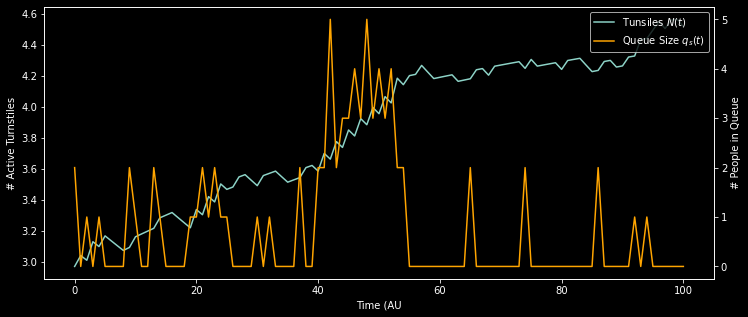

In [17]:
# Simple model simulation 

import numpy as np
import random 
import matplotlib.pyplot as plt

# Parameters
alpha= .05 # replication rate constant - turnstiles/time 
gamma= .01 # decay rate constant - turnstiles/time
mu= 1 # max per-trunstile capacity - people/time
lambda_arrivals= 1.0 # average number of arrivals (Poisson) - people

# Initial conditions
q_s= 1 # initial number of people in the queue
N= 3 # initial number of turnstiles
s_0= "L" # inital state for each new turnstile
sim_time= 100 # total simulation time - arbitrary units
dt= 1 # timestep 

# transition function for the turnstile FSMs
Q= {'L', 'U'} # FSM states L=locked, U=unlocked
sigma= {'coin', 'push'} # FSM input alphabet

def delta(state, event): 
    '''transition function'''
    if state == 'L' and event == 'coin':
        return 'U'
    if state == 'U' and event == 'push': 
        return 'L'
    else: 
        return state # no transition

# Initialize lists to store the simulation data
turnstiles= [s_0 for _ in range(N)]
time_series= []
queue_series= []
population_series= []

# Define the generating dynamics
'''
def rho(q_s, N): 
    throughput= min(q_s, mu*N)
    return alpha * throughput - gamma * N
'''

# Simulation time-loop
t=0
arrivals=[]
while t<= sim_time:
    # simulate arrivals using a Poisson distribution
    A_t= np.random.poisson(lambda_arrivals * dt)
    q_s+= A_t 
    
    # Troubleshooting: poisson sampling
    arrivals.append(A_t)
    
    # Update FSM states for each turnstile
    throughput= 0
    for i in range(len(turnstiles)): 
        if turnstiles[i] == 'L' and q_s > 0:
            # Randomly simulate someone inserting a coin
            if random.random() < 0.99: # 99% chance that coin is inserted
                turnstiles[i]= delta(turnstiles[i], 'coin')
        elif turnstiles[i] == 'U': 
            # Simulate someone pushing through
            if q_s> 0: 
                turnstiles[i]= delta(turnstiles[i], 'push')
                q_s-= 1 # one person passes
                throughput+= 1
                
    # Numerically integrate the generating dynamics
    dN_dt= alpha* throughput- gamma* N
    N+= dN_dt* dt
    
    # Boundaries - positivity constraints
    N= max(N, 0)
    q_s= max(q_s, 0)
    
    # if generation occurred, add new turnstiles
    '''The replication dynamics for turnstiles are continuous
        but new turnstiles only become functional if they are whole
        the number is rounded to the nearest integer value at each (t)'''
    N_int= int(N) # round to integer number of turnstiles
    if len(turnstiles) < N_int:
        turnstiles.extend([s_0] * (N_int- len(turnstiles)))
    elif len(turnstiles) > N_int: 
        turnstiles= turnstiles[:N_int]
        
    # Record the current series states
    time_series.append(t)
    queue_series.append(q_s)
    population_series.append(N)
    
    # advance the timestep
    t+= dt
    
# Troubleshooting:poisson sampling
print(f'arrivals: {np.mean(arrivals)/dt}')
    
# Plotting
plt.style.use('dark_background')
fig, ax1= plt.subplots(figsize=(12,5))

ax1.plot(time_series, population_series, label="Tunsiles $N(t)$")
ax1.set_xlabel('Time (AU')
ax1.set_ylabel('# Active Turnstiles')
ax1.tick_params(axis='y')

ax2= ax1.twinx()

ax2.plot(time_series, queue_series, color='orange', label='Queue Size $q_s(t)$')
ax2.set_ylabel('# People in Queue')
ax2.tick_params(axis='y')
       
# Make combined legend in upper right corner
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

plt.show()